## Project 4 - Advanced Lane Finding Project

##### By Matthew Zimmer - Future Self-Driving Car Engineer
[GitHub](https://github.com/matthewzimmer) | [LinkedIn](https://www.linkedin.com/in/matthewazimmer)

---

**Advanced Lane Finding Project**

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

[//]: # (Image References)

[image1]: ./examples/undistort_output.png "Undistorted"
[image2]: ./test_images/test1.jpg "Road Transformed"
[image3]: ./examples/binary_combo_example.jpg "Binary Example"
[image4]: ./examples/warped_straight_lines.jpg "Warp Example"
[image5]: ./examples/color_fit_lines.jpg "Fit Visual"
[image6]: ./examples/example_output.jpg "Output"
[video1]: ./project_video.mp4 "Video"

## [Rubric](https://review.udacity.com/#!/rubrics/571/view) Points

### Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  






















---

### Writeup / README

#### 1. Provide a Writeup / README that includes all the rubric points and how you addressed each one.  You can submit your writeup as markdown or pdf.  [Here](https://github.com/udacity/CarND-Advanced-Lane-Lines/blob/master/writeup_template.md) is a template writeup for this project you can use as a guide and a starting point.  

You're reading it!

---

#### Python imports

In [3]:
import numpy as np
import cv2
import glob
import os
import pickle

import matplotlib
matplotlib.use('qt5agg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from IPython.core.display import Image, display

from IPython.display import YouTubeVideo
def render_youtube_video(video_id, width=880, height=495):
    return YouTubeVideo(video_id, width=width, height=height)

/Users/matthewz/anaconda2/envs/carnd/lib/python3.5/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


---

### Camera Calibration

#### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained this result: 

![calibration1.jpg](camera_cal/undistorted/calibration1.jpg)

In [112]:
%matplotlib inline

class PipelineOp:
    def perform(self):
        raise NotImplementedError
    
    def output(self):
        """
        Returns the result from performing this operation.
        """
        return None

class CameraCalibrationOp(PipelineOp):
    
    MODE_INITIALIZED = 0x0
    MODE_CALIBRATING = 0x1
    MODE_CALIBRATED = 0x2
    
    # Bitmask of completed camera calibration stages
    COMPLETED_CALIBRATION_STAGES = 0x0    
    
    STAGE_OBTAINED_CALIBRATION_IMAGES = 0x1<<0
    STAGE_COMPUTED_OBJ_AND_IMG_POINTS = 0x1<<1
    STAGE_CALCULATED_CAMERA_MTX_AND_DIST_COEFFICIENTS = 0x1<<2
    STAGE_UNDISTORED_CALIBRATION_IMAGES = 0x1<<3
    STAGE_SAVED_MTX_AND_DIST_CALIBRATIONS = 0x1<<4
    
    def __init__(self, calibration_images, x_inside_corners=9, y_inside_corners=6, calibration_results_pickle_file="camera_cal/camera_mtx_and_dist_pickle.p"):
        PipelineOp.__init__(self)
        
        self.__mode = self.MODE_INITIALIZED
        
        # Images taken by a camera for which this class calibrates by 
        # calculating the object and image points used to undistort 
        # any image take by the same camera.
        self.__calibration_images = calibration_images
        
        self.__x_inside_corners = x_inside_corners
        self.__y_inside_corners = y_inside_corners
        
        # Arrays to store object points and image points from all the images.
        self.__objpoints = [] # 3d points in real world space
        self.__imgpoints = [] # 2d points in image plane
        
        # Computed using cv2.calibrateCamera() in __compute_camera_matrix_and_distortion_coefficients
        self.__camera_matrix = None
        self.__distortion_coefficients = None
        
        # The location of the pickle file where our camera calibration matrix and 
        # distortion coefficients are persisted to
        self.__calibration_results_pickle_file = calibration_results_pickle_file
        
        self.__apply_stage(self.STAGE_OBTAINED_CALIBRATION_IMAGES)

    def perform(self):
        print(self)
        
        self.__mode = self.MODE_CALIBRATING
        print(self)
        
        self.__compute_obj_and_img_points()
        print(self)
        
        self.__compute_camera_matrix_and_distortion_coefficients(self.__calibration_images[0])
        print(self)
        
        self.__save_calibration_mtx_and_dist()
        print(self)
        
        self.__undistort_chessboard_images()
        print(self)
        
        self.__mode = self.MODE_CALIBRATED
        print(self)
        
        return self
        
    def output(self):
        return {
            'matrix': self.__camera_matrix,
            'dist_coefficients': self.__distortion_coefficients,
            'objpoints': self.__objpoints,
            'imgpoints': self.__imgpoints
        }
    
    def undistort(self, img):
        """
        A function that takes an image and performs the camera calibration, 
        image distortion correction and returns the undistorted image
        """
        img = np.copy(img)
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(self.__objpoints, self.__imgpoints, img.shape[0:2][::-1], None, None)
        return cv2.undistort(img, mtx, dist, None, mtx)

    # PRIVATE
    
    def __detect_corners(self, img, nx, ny):
        """
        This function converts an RGB chessboard image to grayscale and finds the 
        chessboard corners using cv2.findChessboardCorners.
        """
        img = np.copy(img)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        return cv2.findChessboardCorners(gray, (nx,ny), None)
    
    def __compute_obj_and_img_points(self):
        """
        A function which iterates over all self.calibration_images and detects all 
        chessboard corners for each.

        For each image corners are detected, a copy of that image with the corners 
        drawn on are saved to camera_cal/corners_found
        """
        if not self.__is_stage_complete(self.STAGE_COMPUTED_OBJ_AND_IMG_POINTS):
            nx, ny = self.__x_inside_corners, self.__y_inside_corners

            # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
            objp = np.zeros((nx*ny,3), np.float32)
            objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

            # Step through the list and search for chessboard corners
            for fname in self.__calibration_images:
                img = mpimg.imread(fname)
                ret, corners = self.__detect_corners(img, nx, ny)

                # If found, add object points, image points
                if ret == True:
                    self.__objpoints.append(objp)
                    self.__imgpoints.append(corners)

                    print("{} corners detected".format(os.path.basename(fname)))
                    calibrated_name = 'camera_cal/corners_found/{}'.format(str(os.path.basename(fname)))
                    cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
                    cv2.imwrite(calibrated_name, img)
            
            self.__apply_stage(self.STAGE_COMPUTED_OBJ_AND_IMG_POINTS)
    
    def __undistort_chessboard_images(self):
        if self.__is_stage_complete(self.STAGE_COMPUTED_OBJ_AND_IMG_POINTS) and not self.__is_stage_complete(self.STAGE_UNDISTORED_CALIBRATION_IMAGES):
            # Step through the list and search for chessboard corners
            for fname in self.__calibration_images:
                img = mpimg.imread(fname)
                undistorted = self.undistort(img)

                print("{} undistorted".format(os.path.basename(fname)))
                undist_file = 'camera_cal/undistorted/{}'.format(os.path.basename(fname))
                cv2.imwrite(undist_file, undistorted)
            
            self.__apply_stage(self.STAGE_UNDISTORED_CALIBRATION_IMAGES)
    
    def __compute_camera_matrix_and_distortion_coefficients(self, distorted_image_path):
        if self.__is_stage_complete(self.STAGE_COMPUTED_OBJ_AND_IMG_POINTS) and not self.__is_stage_complete(self.STAGE_CALCULATED_CAMERA_MTX_AND_DIST_COEFFICIENTS):
            fname = distorted_image_path
            img = mpimg.imread(fname)
            ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(self.__objpoints, self.__imgpoints, img.shape[0:2][::-1], None, None)
            
            self.__camera_matrix = mtx
            self.__distortion_coefficients = dist
            
            self.__apply_stage(self.STAGE_CALCULATED_CAMERA_MTX_AND_DIST_COEFFICIENTS)
            
    def __save_calibration_mtx_and_dist(self):
        """
        Saves a pickled representation of the camera calibration matrix and 
        distortion coefficient results for the provided image for later use
        """
        if self.__is_stage_complete(self.STAGE_COMPUTED_OBJ_AND_IMG_POINTS) and not self.__is_stage_complete(self.STAGE_SAVED_MTX_AND_DIST_CALIBRATIONS):
            dist_pickle = {}
            dist_pickle["mtx"] = self.__camera_matrix
            dist_pickle["dist"] = self.__distortion_coefficients
            pickle.dump( dist_pickle, open( self.__calibration_results_pickle_file, "wb" ) )

            print('camera matrix and distortion coefficients pickled to "{}" for later use'.format(self.__calibration_results_pickle_file))
            
            self.__apply_stage(self.STAGE_SAVED_MTX_AND_DIST_CALIBRATIONS)

    def __is_stage_complete(self, flag):
        return self.COMPLETED_CALIBRATION_STAGES&flag==flag
    
    def __apply_stage(self, flag):
        """Marks a stage as complete"""
        self.COMPLETED_CALIBRATION_STAGES = self.COMPLETED_CALIBRATION_STAGES|flag

    def __str__(self):
        s = []
        
        s.append('')
        s.append('')
        s.append('-------------------------------------------------------------')
        s.append('')
        s.append('[ CALIBRATION MODES ]')
        s.append('')
        s.append('   Initialized? {}'.format('YES' if self.__mode==self.MODE_INITIALIZED else 'NO'))
        s.append('   Calibrating? {}'.format('YES' if self.__mode==self.MODE_CALIBRATING else 'NO'))
        s.append('   Calibration complete? {}'.format('YES' if self.__mode==self.MODE_CALIBRATED else 'NO'))
        s.append('')
        s.append('')
        
        s.append('[ CALIBRATION STAGES - {} ]'.format(self.COMPLETED_CALIBRATION_STAGES))
        s.append('')
        s.append('   Obtained calibration images? {}'.format('YES' if self.__is_stage_complete(self.STAGE_OBTAINED_CALIBRATION_IMAGES) else 'NO'))
        s.append('   Computed object/image points? {}'.format('YES' if self.__is_stage_complete(self.STAGE_COMPUTED_OBJ_AND_IMG_POINTS) else 'NO'))
        s.append('   Calculated camera matrix and distortion coefficients? {}'.format('YES' if self.__is_stage_complete(self.STAGE_CALCULATED_CAMERA_MTX_AND_DIST_COEFFICIENTS) else 'NO'))
        s.append('   Undistored calibration images? {}'.format('YES' if self.__is_stage_complete(self.STAGE_UNDISTORED_CALIBRATION_IMAGES) else 'NO'))
        s.append('   Persisted camera matrix and distortion coefficients? {}'.format('YES' if self.__is_stage_complete(self.STAGE_SAVED_MTX_AND_DIST_CALIBRATIONS) else 'NO'))
        s.append('')
        
        s.append('[ PARAMS ]')
        s.append('')
        s.append('Number calibration images: {}'.format(len(self.__calibration_images)))
        s.append('X inside corners = {}'.format(self.__x_inside_corners))
        s.append('Y inside corners = {}'.format(self.__y_inside_corners))
        s.append('')
        # s.append('output = {}'.format(str(self.output())))
        
        s.append('')
        s.append('')
        
        return '\n'.join(s)


class ColorSpaceConvertOp(PipelineOp):
    def __init__(self, img, color_space, color_channel=-1):
        """
        Converts an image to a different color space.
        
        Available color spaces: HSV, HLS, YUV, GRAY
        """
        PipelineOp.__init__(self)
        self.__img = np.copy(img)
        self.__color_space = color_space
        self.__color_channel = color_channel
        self.__output = None

    def output(self):
        return self.__output
    
    def perform(self):
        if self.__color_space.lower() == 'hsv':
            img = cv2.cvtColor(self.__img, cv2.COLOR_RGB2HSV).astype(np.float)
        if self.__color_space.lower() == 'hls':
            img = cv2.cvtColor(self.__img, cv2.COLOR_RGB2HLS).astype(np.float)
        if self.__color_space.lower() == 'yuv':
            img = cv2.cvtColor(self.__img, cv2.COLOR_RGB2YUV).astype(np.float)
        if self.__color_space.lower() == 'gray':
            img = cv2.cvtColor(self.__img, cv2.COLOR_RGB2GRAY).astype(np.float)
        if self.__color_channel > -1:
            img = img[:,:,self.__color_channel]
        self.__output = img
        return self


class ColorThreshOp(PipelineOp):
    def __init__(self, gray_img, color_thresh=(0, 255)):
        PipelineOp.__init__(self)
        self.__img = np.copy(gray_img)
        self.__color_thresh = color_thresh
        self.__output = None

    def output(self):
        return self.__output
    
    def perform(self):
        # ret, thresholded_img = cv2.threshold(img.astype('uint8'), self._color_thresh[0], self._color_thresh[1], cv2.THRESH_BINARY)
        # self._thresholded_img = thresholded_img
        # self._binary_img = binary_img
        binary = np.zeros_like(self.__img)
        binary[(self.__img > self.__color_thresh[0]) & (self.__img <= self.__color_thresh[1])] = 1
        self.__output = binary
        return self


class UndistortOp(PipelineOp):
    def __init__(self, img, camera_calibration_op):
        """
        Takes an image and cam and performs image distortion correction
        """
        PipelineOp.__init__(self)
        self.__img = np.copy(img)
        self.__camera_calibration_op = camera_calibration_op
        self.__output = None
    
    def output(self):
        return self.__output
    
    def perform(self):
        self.__output = self.__camera_calibration_op.undistort(self.__img)
        return self

        
class SobelThreshOp(PipelineOp):
    def __init__(self, gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
        PipelineOp.__init__(self)
        self.__img = np.copy(gray)
        self.__orient = orient
        self.__sobel_kernel = sobel_kernel # Choose a larger odd number to smooth gradient measurements
        self.__thresh = thresh
        self.__output = None
    
    def output(self):
        return self.__output
        
    def perform(self):
        gray = self.__img
        sobel = cv2.Sobel(gray, cv2.CV_64F, self.__orient=='x', self.__orient!='x', ksize=self.__sobel_kernel)
        abs_sobel = np.absolute(sobel)
        scaled_sobel = (255*abs_sobel/np.max(abs_sobel)).astype(np.uint8) 
        binary = np.zeros_like(scaled_sobel)
        binary[(scaled_sobel >= self.__thresh[0]) & (scaled_sobel <= self.__thresh[1])] = 1
        self.__output = binary
        return self

        
class MagnitudeGradientThreshOp(PipelineOp):
    def __init__(self, gray_img, sobel_kernel=3, thresh=(0, 255)):
        PipelineOp.__init__(self)
        self.__img = np.copy(gray_img)
        self.__sobel_kernel = sobel_kernel # Choose a larger odd number to smooth gradient measurements
        self.__thresh = thresh
        self.__output = None
    
    def output(self):
        return self.__output
        
    def perform(self):
        gray = self.__img
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=self.__sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=self.__sobel_kernel)
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        gradmag = (255*gradmag/np.max(gradmag)).astype(np.uint8) 
        binary = np.zeros_like(gradmag)
        binary[(gradmag >= self.__thresh[0]) & (gradmag <= self.__thresh[1])] = 1
        self.__output = binary
        return self

        
class DirectionGradientThreshOp(PipelineOp):
    """
    Calculates the gradient direction of detected lines 
    """
    def __init__(self, gray_img, sobel_kernel=3, thresh=(0, np.pi/2)):
        PipelineOp.__init__(self)
        self.__img = np.copy(gray_img)
        self.__sobel_kernel = sobel_kernel # Choose a larger odd number to smooth gradient measurements
        self.__thresh = thresh
        self.__output = None
    
    def output(self):
        return self.__output
        
    def perform(self):
        sobelx = cv2.Sobel(self.__img, cv2.CV_64F, 1, 0, ksize=self.__sobel_kernel)
        sobely = cv2.Sobel(self.__img, cv2.CV_64F, 0, 1, ksize=self.__sobel_kernel)
        with np.errstate(divide='ignore', invalid='ignore'):
            abs_grad_dir = np.absolute(np.arctan(sobely/sobelx))
            binary = np.zeros_like(abs_grad_dir)
            binary[(abs_grad_dir > self.__thresh[0]) & (abs_grad_dir < self.__thresh[1])] = 1
        self.__output = binary
        return self

        
class WarperOp(PipelineOp):
    
    def __init__(self, gray_img, src_pts, dst_pts):
        PipelineOp.__init__(self)
        self.__img = np.copy(gray_img)
        self.__src_pts = src_pts
        self.__dst_pts = dst_pts
        self.__transform_matrix = None
        self.__output = None
    
    def output(self):
        return self.__output
    
    def perform(self):
        # use cv2.getPerspectiveTransform() to get M, the transform matrix
        self.__transform_matrix = cv2.getPerspectiveTransform(self.__src_pts, self.__dst_pts)

        # use cv2.warpPerspective() to warp the image to a top-down view
        self.__output = cv2.warpPerspective(self.__img, self.__transform_matrix, self.__img.shape[0:2][::-1], flags=cv2.INTER_LINEAR)
        return self
    
    def __str__(self):
        s = []

        s.append(' source image shape: ')
        s.append('')
        s.append('   '+str(self.__img.shape))
        s.append('')

        s.append(' source points: ')
        s.append('')
        s.append('   top.L: '+str(self.__src_pts[0]))
        s.append('   bot.L: '+str(self.__src_pts[1]))
        s.append('   bot.R: '+str(self.__src_pts[2]))
        s.append('   top.R: '+str(self.__src_pts[3]))
        s.append('')

        s.append(' desination points: ')
        s.append('')
        s.append('   top.L: '+str(self.__dst_pts[0]))
        s.append('   bot.L: '+str(self.__dst_pts[1]))
        s.append('   bot.R: '+str(self.__dst_pts[2]))
        s.append('   top.R: '+str(self.__dst_pts[3]))
        s.append('')
        
        s.append(' warped image shape: ')
        s.append('')
        if not self.__output is None:
            s.append('   '+str(self.__output.shape))
        else:
            s.append('   '+str(None))
        s.append('')
        
        s.append(' transform matrix: ')
        s.append('')
        s.append('   '+str(self.__transform_matrix))
        s.append('')
        s.append('')
        
        s.append('')
        
        return '\n'.join(s)
    
class PlotImageOp(PipelineOp):
    def __init__(self, img, cmap='gray', interpolation='none', aspect='auto'):
        PipelineOp.__init__(self)
        self.__img = np.copy(img)
        self.__cmap = cmap
        self.__interpolation = interpolation
        self.__aspect = aspect

    def perform(self):
        fig1 = plt.figure(figsize=(10,8))
        ax = fig1.add_subplot(111)
        ax.imshow(self.__img, cmap=self.__cmap, interpolation=self.__interpolation, aspect=self.__aspect)
        plt.tight_layout()
        plt.show()
        return self

In [8]:
# base edges - doesn't work for all images in camera_cal directory (i.e., 1, 4, 5)
calibration_images=glob.glob('camera_cal/calibration*.jpg')
nx = 9
ny = 6

calibration_op = CameraCalibrationOp(calibration_images=calibration_images, x_inside_corners=nx, y_inside_corners=ny)
calibration_op.perform()



-------------------------------------------------------------

[ CALIBRATION MODES ]

   Initialized? YES
   Calibrating? NO
   Calibration complete? NO


[ CALIBRATION STAGES - 1 ]

   Obtained calibration images? YES
   Computed object/image points? NO
   Calculated camera matrix and distortion coefficients? NO
   Undistored calibration images? NO
   Persisted camera matrix and distortion coefficients? NO

[ PARAMS ]

Number calibration images: 20
X inside corners = 9
Y inside corners = 6





-------------------------------------------------------------

[ CALIBRATION MODES ]

   Initialized? NO
   Calibrating? YES
   Calibration complete? NO


[ CALIBRATION STAGES - 1 ]

   Obtained calibration images? YES
   Computed object/image points? NO
   Calculated camera matrix and distortion coefficients? NO
   Undistored calibration images? NO
   Persisted camera matrix and distortion coefficients? NO

[ PARAMS ]

Number calibration images: 20
X inside corners = 9
Y inside corners = 6



---

### Pipeline (single images)

#### 1. Provide an example of a distortion-corrected image.

To demonstrate this step, I will describe how I apply the distortion correction to one of the test images like this one:

![alt text](test_images/test4.jpg)

In the previous step, the calibration matrix and distortion coefficients were calculated and preserved inside of our instance of **CameraCalibrationOp**. This makes it trivial for us to undistort any image taken by the camera for which it was calibrated for via the exposed public _CameraCalibrationOp#undistort_ method which accepts a single argument corresponding to a numpy image array and returns an undistored numpy array representation of the original image after calling _cv2.undistort_.

Therefore, I simply read in _test_images/test4.jpg_ and pass it to **CameraCalibrationOp#undistort** via my instance of **CameraCalibrationOp**, _calibration_op_, as shown in the next cell.

The simplest indication that distortion correction occurred is by observing the white car in the Distored version and comparing it to the Undistored version. Notice how the undistored version appears to stretch and straighten the car out, essentially unrolling the convexed pixels from the lens distortion as if you were unrolling pizza crust after having just folded the edges to form the crust edges.

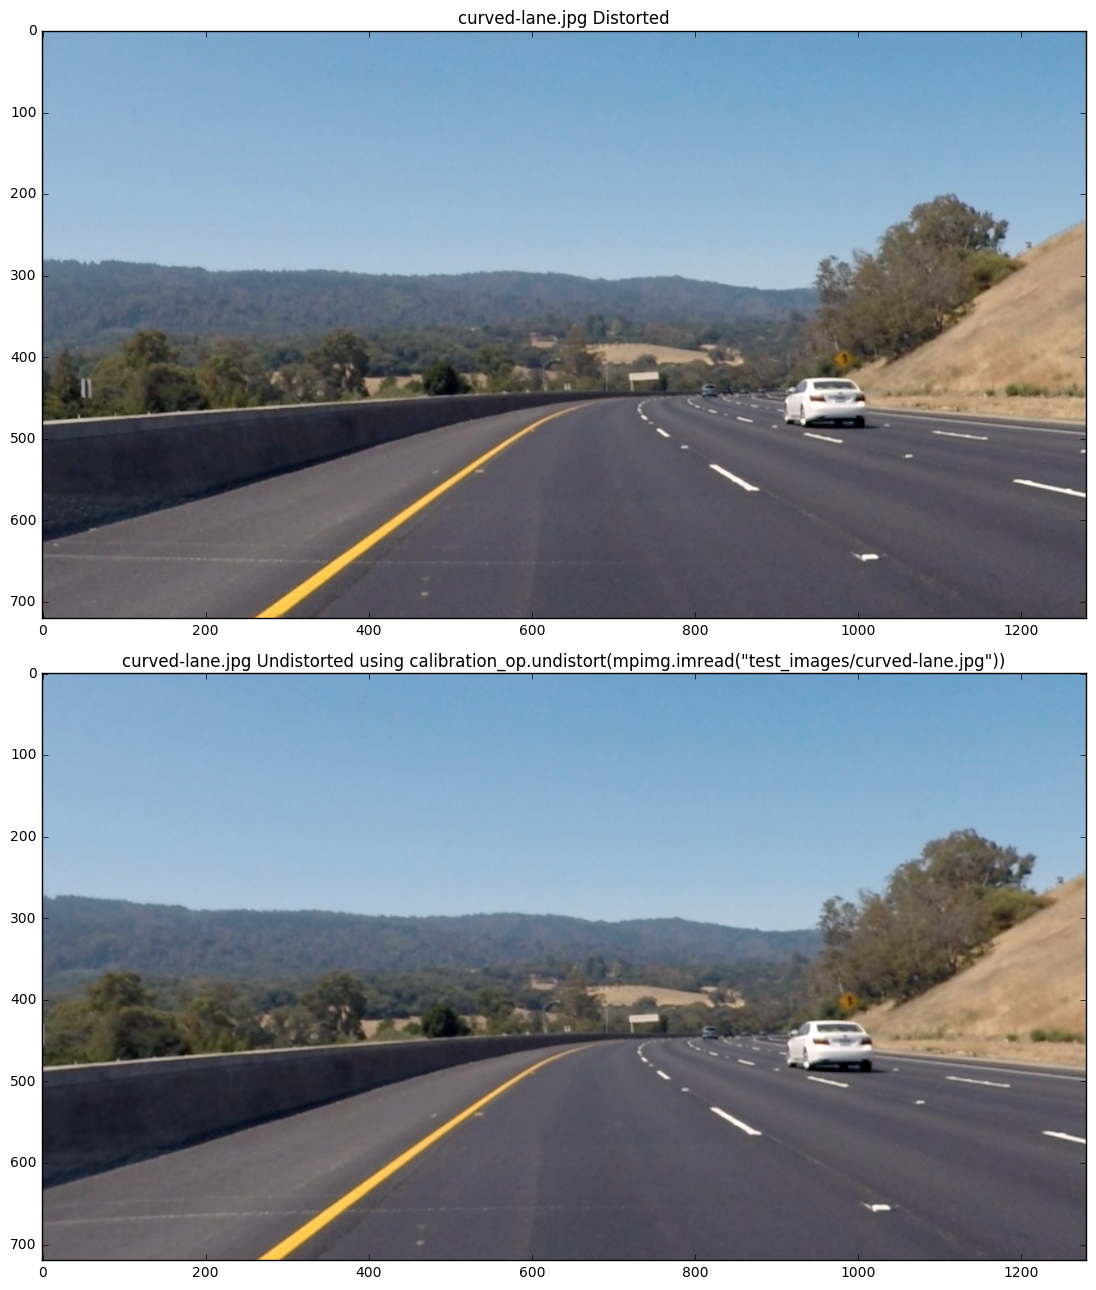

In [115]:
test_image = 'test_images/curved-lane.jpg'
img = mpimg.imread(test_image)
img_size = (img.shape[1], img.shape[0])

# UndistortOp
undistort_op = UndistortOp(img, calibration_op)
undistort_op.perform()
undistorted = undistort_op.output()

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,13))
plt.tight_layout()
ax1.set_title(os.path.basename(test_image)+' Distorted')
ax1.imshow(img)

ax2.set_title(os.path.basename(test_image)+' Undistorted using calibration_op.undistort(mpimg.imread("{}"))'.format(test_image))
ax2.imshow(undistorted)
plt.tight_layout()

---

#### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.
I used a combination of color and gradient thresholds to generate a binary image (thresholding steps at lines # through # in `another_file.py`).  Here's an example of my output for this step.  (note: this is not actually from one of the test images)

![alt text][image3]

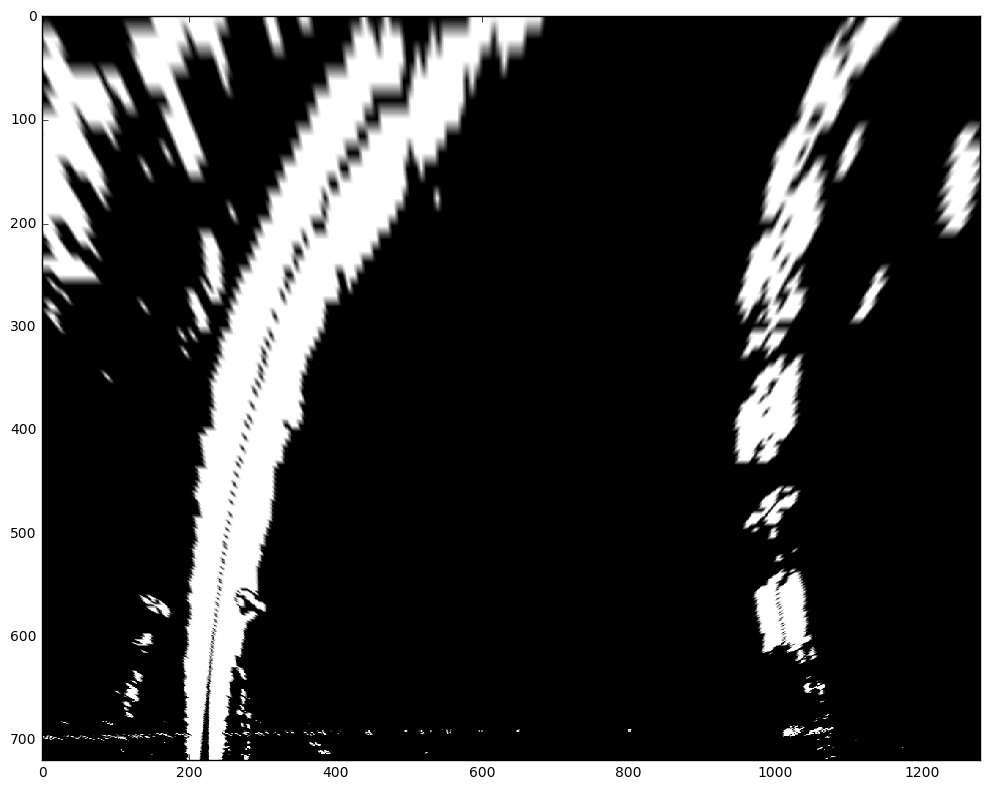

In [126]:
ksize = 9

# PlotImageOp(undistorted, cmap=None).perform()

# HSV
hsv = ColorSpaceConvertOp(undistorted, color_space='hsv', color_channel=2).perform().output()
# PlotImageOp(hsv).perform()

# sobel X
gradx = SobelThreshOp(hsv, orient='x', sobel_kernel=ksize, thresh=(10, 150)).perform().output()
# PlotImageOp(gradx).perform()

# sobel Y
grady = SobelThreshOp(hsv, orient='y', sobel_kernel=ksize, thresh=(10, 150)).perform().output()
# PlotImageOp(grady).perform()

# magnitude gradient
mag_binary = MagnitudeGradientThreshOp(hsv, sobel_kernel=ksize, thresh=(10, 250)).perform().output()
# PlotImageOp(mag_binary).perform()

# direction gradient
dir_binary = DirectionGradientThreshOp(hsv, sobel_kernel=ksize, thresh=(0.3, 1.3)).perform().output()
# PlotImageOp(dir_binary).perform()

# combined
combined = np.zeros_like(hsv)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
# PlotImageOp(combined).perform()

# warped binary
src_pts = np.float32(
    [[(img_size[0] / 2) - 25, img_size[1] / 2 + 100],
    [((img_size[0] / 6) + 55), img_size[1]],
    [(img_size[0] * 5 / 6) + 90, img_size[1]],
    [(img_size[0] / 2 + 85), img_size[1] / 2 + 100]])

dst_pts = np.float32(
    [[(img_size[0] / 6), 0],
    [(img_size[0] / 6), img_size[1]],
    [(img_size[0] * 5 / 6), img_size[1]],
    [(img_size[0] * 5 / 6), 0]])

warped_binary = WarperOp(combined, src_pts, dst_pts).perform().output()
PlotImageOp(warped_binary).perform()

if False:
    f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(7, 1, figsize=(80,40))

    ax1.set_title(os.path.basename(test_image)+' Undistorted')
    ax1.imshow(undistorted)
    
    ax2.set_title(os.path.basename(test_image)+' HS[V]')
    ax2.imshow(hsv, cmap='gray')

    ax3.set_title(os.path.basename(test_image)+' AbsSobelX')
    ax3.imshow(gradx, cmap='gray')

    ax4.set_title(os.path.basename(test_image)+' AbsSobelY')
    ax4.imshow(grady, cmap='gray')

    ax5.set_title(os.path.basename(test_image)+' Mag. Grad.')
    ax5.imshow(mag_binary, cmap='gray')

    ax6.set_title(os.path.basename(test_image)+' Dir. Grad.')
    ax6.imshow(dir_binary, cmap='gray')
    
    ax7.set_title(os.path.basename(test_image)+' (AbsSobelX&AbsSobelY) | (MagnitudeGrad&DirectionGrad)')
    ax7.imshow(combined, cmap='gray')

    plt.tight_layout()

---

#### 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

The code for my perspective transform includes a **PipelineOp** subclass called **WarperOp**, which appears in lines ? through ? in the file `pipeline_operations.py` (pipeline_operations.py) (or, for example, in the next code cell of this IPython notebook).  The **WarperOp** class takes as inputs an image (`img`), as well as source (`src_pts`) and destination (`dst_pts`) points.  I chose to hardcode the source and destination points in the following manner:

```python
src_pts = np.float32(
    [[(img_size[0] / 2) - 35, img_size[1] / 2 + 100],
    [((img_size[0] / 6) + 55), img_size[1]],
    [(img_size[0] * 5 / 6) + 90, img_size[1]],
    [(img_size[0] / 2 + 85), img_size[1] / 2 + 100]])

dst_pts = np.float32(
    [[(img_size[0] / 6), 0],
    [(img_size[0] / 6), img_size[1]],
    [(img_size[0] * 5 / 6), img_size[1]],
    [(img_size[0] * 5 / 6), 0]])
```

This resulted in the following source and destination points:

| Source        | Destination   | 
|:-------------:|:-------------:| 
| 605, 460      | 213, 0        | 
| 268, 720      | 213, 720      |
| 1157, 720     | 1067, 720      |
| 725, 460      | 1067, 0        |

I verified that my perspective transform was working as expected by drawing the `src_pts` and `dst_pts` points onto a test image and its warped counterpart to verify that the lines appear parallel in the warped image.

![test_image](warped/polylines_warped_test6.jpg)

 source image shape: 

   (720, 1280, 3)

 source points: 

   top.L: [ 605.  460.]
   bot.L: [ 268.33334351  720.        ]
   bot.R: [ 1156.66662598   720.        ]
   top.R: [ 725.  460.]

 desination points: 

   top.L: [ 213.33332825    0.        ]
   bot.L: [ 213.33332825  720.        ]
   bot.R: [ 1066.66662598   720.        ]
   top.R: [ 1066.66662598     0.        ]

 warped image shape: 

   (720, 1280, 3)

 transform matrix: 

   [[ -6.88528031e-01  -1.40022765e+00   1.04000835e+03]
 [ -1.07691633e-14  -1.98489698e+00   9.13052613e+02]
 [ -1.43114687e-17  -2.38440049e-03   1.00000000e+00]]





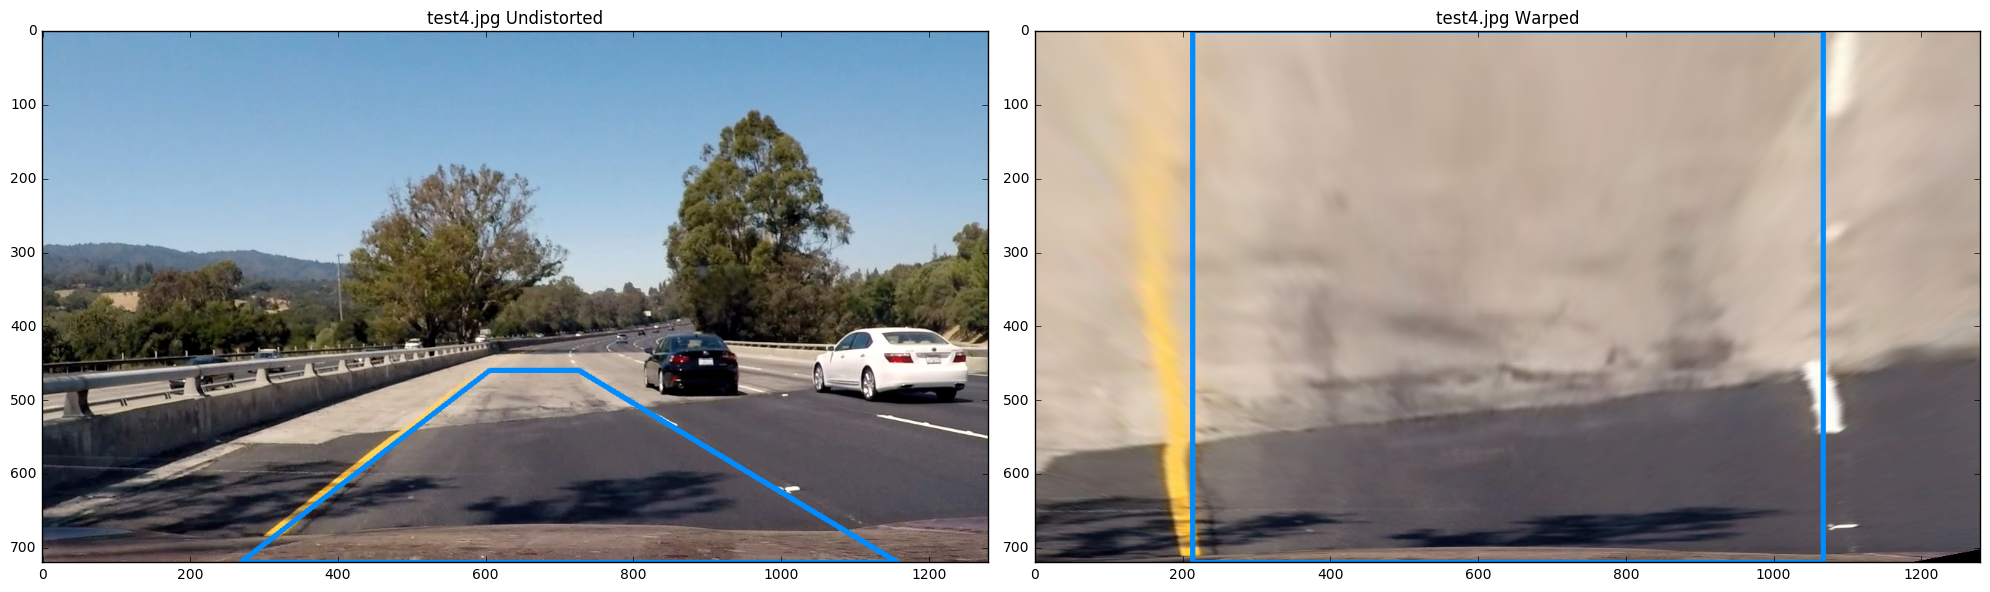

In [113]:
src_pts = np.float32(
    [[(img_size[0] / 2) - 35, img_size[1] / 2 + 100],
    [((img_size[0] / 6) + 55), img_size[1]],
    [(img_size[0] * 5 / 6) + 90, img_size[1]],
    [(img_size[0] / 2 + 85), img_size[1] / 2 + 100]])

dst_pts = np.float32(
    [[(img_size[0] / 6), 0],
    [(img_size[0] / 6), img_size[1]],
    [(img_size[0] * 5 / 6), img_size[1]],
    [(img_size[0] * 5 / 6), 0]])

# warp our test image
warper_op = WarperOp(calibration_op.undistort(img), src_pts, dst_pts)
warper_op.perform()
warped_img = warper_op.output()

# save the warped image to disk for visualization purposes
if not os.path.exists('warped'):
    os.makedirs('warped')
cv2.imwrite('warped/warped_'+os.path.basename(test_image), cv2.cvtColor(warped_img, cv2.COLOR_RGB2BGR))

# print some information about our warper operation
print(warper_op)

# plot the results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,13))
plt.tight_layout()
ax1.set_title(os.path.basename(test_image)+' Undistorted')

pts = np.array([src_pts], np.int32)
cv2.polylines(img,[pts],True,(0, 140, 255),thickness=5)
ax1.imshow(img)
cv2.imwrite('warped/polylines_'+os.path.basename(test_image), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

ax2.set_title(os.path.basename(test_image)+' Warped')
img = warped_img
pts = np.array([dst_pts], np.int32)
cv2.polylines(img,[pts],True,(0, 140, 255),thickness=5)
ax2.imshow(img)
cv2.imwrite('warped/polylines_warped_'+os.path.basename(test_image), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

plt.tight_layout()

---

#### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

Then I did some other stuff and fit my lane lines with a 2nd order polynomial kinda like this:

![alt text][image5]

---

#### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

I did this in lines # through # in my code in `my_other_file.py`

---

#### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

I implemented this step in lines # through # in my code in `yet_another_file.py` in the function `map_lane()`.  Here is an example of my result on a test image:

![alt text][image6]

---

### Pipeline (video)

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

Here's a [link to my video result](./project_video.mp4)

---

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

Here I'll talk about the approach I took, what techniques I used, what worked and why, where the pipeline might fail and how I might improve it if I were going to pursue this project further.  